# **Supervised Learning – 4th Assignment**

## Auteurs: 
### **ESSOH Lath**
### **SOW Oumou**
### **RAZAFINDRAKOTO Tsiba**

# Etude: Détecter les entreprises à forte croissance 

# Étape 1 : Prétraitement des Données

## Chargement et Exploration des Données

In [2]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
data = pd.read_csv('data_hgf.csv')

print(data.columns)

# Aperçu des données
print(data.info())

Index(['Unnamed: 0', '...1', 'id', 'year', 'yearest', 'industry', 'pertot',
       'enggrad', 'sales', 'va', 'gom', 'rdint', 'reext', 'ipnc', 'ipnf',
       'ipnm', 'ipr', 'patent'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121992 entries, 0 to 121991
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  121992 non-null  int64  
 1   ...1        121992 non-null  float64
 2   id          121992 non-null  int64  
 3   year        121992 non-null  int64  
 4   yearest     54076 non-null   float64
 5   industry    42555 non-null   float64
 6   pertot      42555 non-null   float64
 7   enggrad     48553 non-null   float64
 8   sales       42451 non-null   float64
 9   va          42157 non-null   float64
 10  gom         42149 non-null   float64
 11  rdint       42272 non-null   float64
 12  reext       42448 non-null   float64
 13  ipnc        40330 non-null   float64
 14  ipnf   

## Identification des Valeurs Manquantes

In [5]:
# Afficher le nombre de valeurs manquantes pour chaque colonne
missing_values_columns = data.isnull().sum()
print("Nombre de valeurs manquantes pour chaque colonne:")
print(missing_values_columns)

Nombre de valeurs manquantes pour chaque colonne:
Unnamed: 0        0
...1              0
id                0
year              0
yearest       67916
industry      79437
pertot        79437
enggrad       73439
sales         79541
va            79835
gom           79843
rdint         79720
reext         79544
ipnc          81662
ipnf          81665
ipnm          81660
ipr           79454
patent        79504
dtype: int64


## Traitement des valeurs manquantes 

Pour gérer les valeurs manquantes, nous avons choisi une approche différente selon le type de variable.

- Variables Binaires : Pour les variables binaires (ipnc, ipnf, ipnm, ipr), nous avons utilisé le mode pour chaque entreprise (id). Cette méthode est logique car les valeurs binaires (0 ou 1) sont discrètes, et leur mode représente l'état le plus fréquent pour chaque entreprise sur la période.

In [10]:
# Pour les variables binaires : mode pour chaque entreprise
binary_vars = ['ipnc', 'ipnf', 'ipnm', 'ipr']
for var in binary_vars:
    data[var] = data.groupby('id')[var].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 0))

- Variables Continues : Pour les variables continues comme sales, pertot, gom, etc., nous avons utilisé la moyenne par entreprise. Cela permet de maintenir une certaine cohérence temporelle pour chaque entreprise tout en réduisant les biais.

In [15]:
# Imputation des valeurs manquantes par la moyenne pour chaque entreprise
continuous_vars = ['sales', 'pertot', 'gom', 'va', 'rdint', 'reext']
for var in continuous_vars:
    data[var] = data.groupby('id')[var].transform(lambda x: x.fillna(x.mean()))

In [17]:
# Imputation par la moyenne pour 'enggrad' par entreprise
data['enggrad'] = data.groupby('id')['enggrad'].transform(lambda x: x.fillna(x.mean()))

- Variable de Catégorie (industry) et Date (yearest) : Ici, nous avons également utilisé le mode pour chaque entreprise. Cela permet de remplir les valeurs manquantes avec la catégorie ou l'année la plus courante, évitant ainsi de créer des anomalies avec des valeurs rares.

In [20]:
# Imputer 'yearest' par le mode pour chaque entreprise
data['yearest'] = data.groupby('id')['yearest'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

In [22]:
# Imputer 'industry' par le mode pour chaque entreprise
data['industry'] = data.groupby('id')['industry'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else data['industry'].mode()[0]))

- Imputation Particulière pour les Brevets (patent) : Nous avons rempli les valeurs manquantes par zéro, supposant que si une entreprise n'a pas de valeur pour le nombre de brevets, elle n'en a probablement pas déposé.

In [25]:
# Remplacer les valeurs manquantes dans 'patent' par 0
data['patent'] = data['patent'].fillna(0)

#### Création de nouvelles variables
Nous avons créé deux variables supplémentaires pour l'analyse :

- Intensité de R&D : Calculée comme le ratio de la somme des dépenses de R&D interne et externe sur les ventes, pour capturer l'effort de l'entreprise en innovation par rapport à sa taille.
- Âge de l’Entreprise : Calculé comme la différence entre l'année courante et l'année d'établissement, pour prendre en compte l'expérience de l'entreprise.

In [28]:
# Créer les nouvelles variables
data['rd_intensity'] = (data['rdint'] + data['reext']) / data['sales']
data['age'] = data['year'] - data['yearest']

In [30]:
# Vérification des valeurs manquantes dans toutes les colonnes
print("\nValeurs manquantes après l'imputation :")
print(data.isnull().sum())


Valeurs manquantes après l'imputation :
Unnamed: 0          0
...1                0
id                  0
year                0
yearest         15962
industry            0
pertot              0
enggrad           644
sales             276
va                483
gom               483
rdint             161
reext             161
ipnc                0
ipnf                0
ipnm                0
ipr                 0
patent              0
rd_intensity      437
age             15962
dtype: int64


In [32]:
# Vérification du nombre de lignes avant la suppression des valeurs manquants
print(f"Nombre de lignes avant suppression des valeurs manquantes : {data.shape[0]}")

Nombre de lignes avant suppression des valeurs manquantes : 121992


## Suppression des Valeurs Manquantes Restantes
Après imputation, nous avions encore des valeurs manquantes. Nous avons alors choisi de supprimer toutes les lignes restantes avec des valeurs manquantes.

Cela garantit que le modèle ne soit pas biaisé par des données incomplètes et réduit le risque d'erreurs dans la modélisation.

In [35]:
# Filtrer les lignes avec des valeurs manquantes dans n'importe quelle colonne
missing_data = data[data.isnull().any(axis=1)]

# Afficher les premières lignes des données avec des valeurs manquantes
print("Lignes avec des valeurs manquantes :")
print(missing_data.head())  # Affiche les 5 premières lignes avec des valeurs manquantes

Lignes avec des valeurs manquantes :
      Unnamed: 0    ...1   id  year  yearest  industry   pertot  enggrad  \
6302        6303  6303.0  275  1990   1968.0       7.0   243.00      NaN   
6303        6304  6304.0  275  1991   1968.0       7.0   251.00      NaN   
6304        6305  6305.0  275  1992   1968.0       7.0   491.00      NaN   
6305        6306  6306.0  275  1993   1968.0       7.0  1100.00      NaN   
6306        6307  6307.0  275  1994   1968.0       7.0   521.25      NaN   

            sales            va        gom         rdint  reext  ipnc  ipnf  \
6302    6358720.0  2.910275e+07  16.166667  0.000000e+00    0.0   0.0   0.0   
6303    8868048.0  7.046891e+06  25.400000  0.000000e+00    0.0   0.0   0.0   
6304  175991153.0  2.662997e+07   8.500000  4.058515e+05    0.0   0.0   0.0   
6305  214479349.0  5.363140e+07  14.600000  1.217554e+06    0.0   0.0   0.0   
6306  101424317.5  2.910275e+07  16.166667  4.058515e+05    0.0   0.0   0.0   

      ipnm  ipr  patent  rd_int

In [37]:
# Sauvegarde de la base de données seulement avec les valeurs manquantes dans un fichier csv
missing_data.to_csv('missing_data.csv', index=False)

print("La base de données avec valeurs manquantes a été sauvegardée dans 'missing_data.csv'.")

La base de données avec valeurs manquantes a été sauvegardée dans 'missing_data.csv'.


In [39]:
### Suppression des valeurs manquantes de la base 
# Supprimer les lignes restantes avec des valeurs manquantes
data_cleaned = data.dropna()

# Vérification des valeurs manquantes
print(data_cleaned.isnull().sum())

Unnamed: 0      0
...1            0
id              0
year            0
yearest         0
industry        0
pertot          0
enggrad         0
sales           0
va              0
gom             0
rdint           0
reext           0
ipnc            0
ipnf            0
ipnm            0
ipr             0
patent          0
rd_intensity    0
age             0
dtype: int64


In [41]:
# Nombre de lignes après suppression des lignes avec valeurs manquantes
print(f"Nombre de lignes restantes après suppression : {data_cleaned.shape[0]}")

Nombre de lignes restantes après suppression : 105156


In [43]:
# Sauvegarde du DataFrame modifié dans un fichier CSV
data_cleaned.to_csv('data_hgf_modified.csv', index=False)

## Calcul des Indicateurs de Croissance et Identification des HGF

Nous avons utilisé une approche basée sur le taux de croissance des ventes pour identifier les entreprises à forte croissance :

- **Calcul du Taux de Croissance des Ventes** : Nous avons calculé la variation en pourcentage des ventes d'une année à l'autre pour chaque entreprise avec pct_change. En spécifiant fill_method=None, nous nous sommes assurés que seules les périodes consécutives sont utilisées, ce qui permet de ne pas générer de valeurs artificielles.
- **Définition du Top 10%** : Nous avons choisi le 90ème percentile comme seuil pour identifier les entreprises dans les 10% les plus performants en termes de croissance des ventes. Cette méthode est robuste car elle prend en compte toute la distribution des taux de croissance.
- **Création de la Variable hgf** : Nous avons ensuite créé une variable binaire hgf pour indiquer si une entreprise fait partie du top 10%. Cela nous permet de facilement distinguer les entreprises à forte croissance pour l’analyse.

In [47]:
# Calculer la croissance des ventes avec .loc
data_cleaned.loc[:, 'sales_growth'] = data_cleaned.groupby('id')['sales'].pct_change()

# Définir la variable binaire HGF avec .loc
top_10_percent_threshold = data_cleaned['sales_growth'].quantile(0.90)
data_cleaned.loc[:, 'hgf'] = (data_cleaned['sales_growth'] >= top_10_percent_threshold).astype(int)


C:\Users\natha\AppData\Local\Temp\ipykernel_7640\4179821096.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned.loc[:, 'sales_growth'] = data_cleaned.groupby('id')['sales'].pct_change()
C:\Users\natha\AppData\Local\Temp\ipykernel_7640\4179821096.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned.loc[:, 'hgf'] = (data_cleaned['sales_growth'] >= top_10_percent_threshold).astype(int)


In [49]:
print(data_cleaned.isnull().sum())

Unnamed: 0         0
...1               0
id                 0
year               0
yearest            0
industry           0
pertot             0
enggrad            0
sales              0
va                 0
gom                0
rdint              0
reext              0
ipnc               0
ipnf               0
ipnm               0
ipr                0
patent             0
rd_intensity       0
age                0
sales_growth    4572
hgf                0
dtype: int64


In [51]:
# Nombre total d'entreprises uniques en utilisant l'identifiant 'id'
nombre_entreprises_uniques = data_cleaned['id'].nunique()
print("Nombre total d'entreprises uniques :", nombre_entreprises_uniques)

Nombre total d'entreprises uniques : 4572


## Analyse des Corrélations et choix des variables 

In [54]:
# Statistiques descriptives pour les variables numériques
numeric_columns = ['pertot', 'enggrad', 'sales', 'va', 'gom', 'rdint', 'reext', 'age', 'rd_intensity', 'hgf', 'sales_growth']
print(data_cleaned[numeric_columns].describe())

              pertot        enggrad         sales            va  \
count  105156.000000  105156.000000  1.051560e+05  1.051560e+05   
mean      201.527954       4.520252  4.176806e+07  1.940781e+07   
std       627.733219       7.430674  2.109109e+08  1.542609e+08   
min         1.000000       0.000000  5.662000e+03 -5.877064e+07   
25%        17.250000       0.000000  1.049545e+06  4.271730e+05   
50%        40.000000       2.166667  3.662445e+06  1.489524e+06   
75%       202.000000       6.050000  2.435618e+07  9.297641e+06   
max     25363.000000     100.000000  7.617339e+09  1.268945e+10   

                 gom         rdint         reext            age  \
count  105156.000000  1.051560e+05  1.051560e+05  105156.000000   
mean        7.302422  3.110435e+05  1.778732e+05      23.364382   
std        22.517112  3.451393e+06  3.482562e+06      21.528662   
min     -1706.000000  0.000000e+00  0.000000e+00     -17.000000   
25%         2.957143  0.000000e+00  0.000000e+00       9.0000

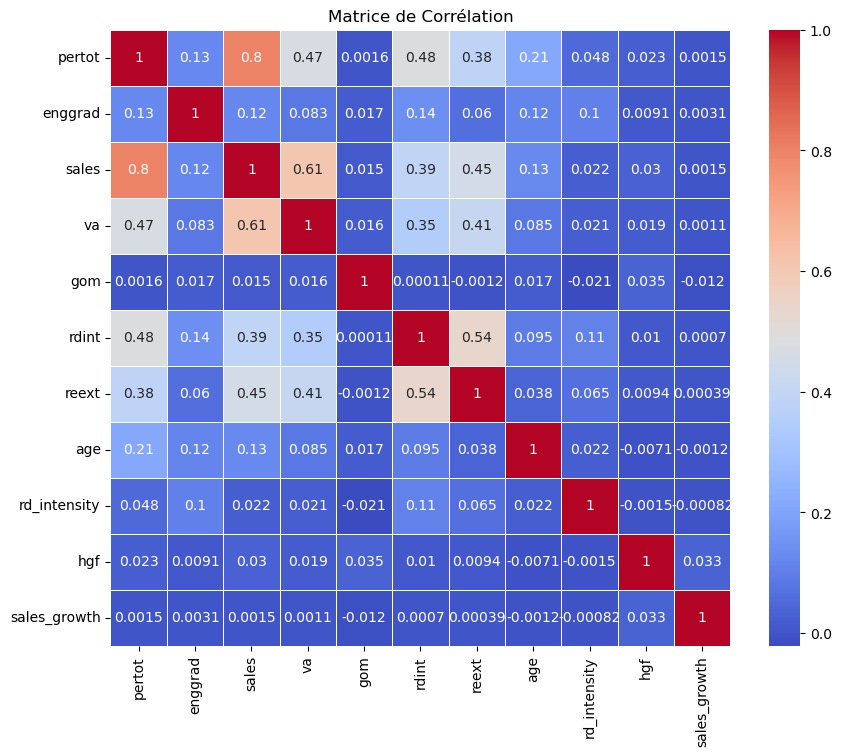

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de corrélation
correlation_matrix = data_cleaned[numeric_columns].corr()

# Visualiser la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice de Corrélation')
plt.show()


#### Constatations
- Variables avec hgf :
  
Toutes les variables ont des corrélations très faibles avec hgf. La corrélation la plus élevée est avec gom (0,035), ce qui est encore très faible.
Cela suggère qu’aucune des variables n'a de relation linéaire forte avec le fait d'être dans le top 10% des entreprises en termes de croissance. Cependant, cela ne signifie pas qu’elles sont toutes sans importance, surtout si on utilise une méthode de régularisation pour identifier les contributions non linéaires ou combinées.

- Variables avec sales_growth :

Encore une fois, les corrélations sont extrêmement faibles, avec la plus élevée entre gom et sales_growth (-0,012).
La faible corrélation pourrait indiquer que la croissance des ventes dépend de facteurs non inclus dans ces variables ou de relations plus complexes (non linéaires).

#### Choix des variables

Dans notre étude, nous avons décidé de concentrer notre analyse sur un sous-ensemble de variables jugées pertinentes : pertot, engrad, va, gom, ipnc, et ipnf. Ce choix est basé sur une évaluation théorique de chaque variable et de son impact potentiel sur la capacité d'une entreprise à devenir une High-Growth Firm (HGF).

Les raisons de notre choix sont les suivantes: 

- **pertot** : Représente les dépenses totales de l'entreprise. Une entreprise avec un niveau de dépenses élevé peut potentiellement avoir des capacités de croissance, car elle pourrait investir dans des ressources ou des projets de développement.
- **engrad** : Indique l'investissement dans le capital humain, ce qui est souvent un facteur de différenciation pour les entreprises en forte croissance. Une main-d'œuvre qualifiée et bien formée peut accélérer l'innovation et la productivité.
- **va** : La valeur ajoutée est un indicateur de la performance économique globale d'une entreprise, ce qui peut être un reflet de sa capacité à croître.
- **gom** : Relatif aux marges et à la gestion de l'entreprise, ce facteur peut influencer la rentabilité, un facteur clé pour les entreprises HGF.
- **ipnc et ipnf** : Ce sont des indicateurs de propriété intellectuelle. Les brevets et autres formes de propriété intellectuelle sont souvent des signes de capacité d'innovation et de différenciation dans un secteur.
  
En limitant notre analyse à ces variables, nous réduisons la complexité du modèle tout en nous concentrant sur des indicateurs qui ont du sens dans le contexte de la croissance rapide des entreprises.

# Étape 2: Modélisations

## Modélisation 1: Comparaison de différents modèles: Logistic Regression - Decision Tree - Random Forest - Gradient Boosting - KNN

### Préparation des Données pour la Modélisation

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Définir les features et la cible pour l'entraînement
features = ['pertot', 'enggrad', 'va', 'gom', 'ipnc', 'ipnf']

# Séparer les données d'entraînement (1990 à 2011) et de test (2012)
train_data = data_cleaned[data_cleaned['year'] <= 2011]  # Données d'entraînement
test_data = data_cleaned[data_cleaned['year'] == 2012]    # Données de test

# Définir les features et la cible pour l'ensemble d'entraînement
X_train = train_data[features]  # Caractéristiques pour l'entraînement
y_train = train_data['hgf']      # Cible pour l'entraînement

# Définir les features pour l'ensemble de test
X_test = test_data[features]      # Caractéristiques pour le test
y_test = test_data['hgf']         # Cible pour le test (si besoin pour l'évaluation)

### Les différents modèles 

In [69]:
# Initialiser les modèles
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier()
}

# Entraîner et évaluer chaque modèle
for name, model in models.items():
    model.fit(X_train, y_train)  # Entraînement
    y_pred = model.predict(X_test)  # Prédiction
    
    # Afficher les résultats
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    
    # Comparaison des vraies valeurs, des prédictions, et des industries
    comparison_df = test_data[['id', 'industry']].copy()  # Copier les colonnes 'id' et 'industry'
    comparison_df['y_test'] = y_test.values               # Ajouter les valeurs réelles de y_test
    comparison_df['y_pred'] = y_pred                      # Ajouter les prédictions de y_pred
    print(f"\nComparaison des vraies valeurs (y_test), des prédictions (y_pred), et des industries pour {name}:\n")
    print(comparison_df)
    
    # Compter les occurrences des industries pour les entreprises HHGF (hgf == 1) dans y_test et y_pred
    hhgf_test_industry_count = comparison_df[comparison_df['y_test'] == 1].groupby('industry').size()
    hhgf_pred_industry_count = comparison_df[comparison_df['y_pred'] == 1].groupby('industry').size()

    print(f"\nOccurrence des industries pour les entreprises HHGF dans le y_test pour {name}:\n")
    print(hhgf_test_industry_count)
    
    print(f"\nOccurrence des industries pour les entreprises HHGF dans le y_pred pour {name}:\n")
    print(hhgf_pred_industry_count)
    
    # Afficher les entreprises prédites comme HHGF (hgf == 1)
    hhgf_pred = comparison_df[comparison_df['y_pred'] == 1]  # Entreprises prédits comme HHGF
    print(f"\nEntreprises prédites comme HHGF par {name} et leurs industries:\n")
    print(hhgf_pred[['id', 'industry']])


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      4334
           1       0.04      0.05      0.04       238

    accuracy                           0.90      4572
   macro avg       0.50      0.50      0.50      4572
weighted avg       0.90      0.90      0.90      4572

Accuracy: 0.8976377952755905

Comparaison des vraies valeurs (y_test), des prédictions (y_pred), et des industries pour Logistic Regression:

          id  industry  y_test  y_pred
22         1      12.0       0       0
45         2      11.0       0       0
68         3       9.0       0       0
91         4      12.0       0       0
114        5      13.0       0       0
...      ...       ...     ...     ...
106374  4625       4.0       0       0
106397  4626      13.0       0       0
106420  4627      19.0       0       0
106443  4628       3.0       0       0
106466  4629      11.0       0       0

[4572 rows x 4 columns]

Occurre

### Constatations et interprétations 

D'abord on constate que la classe 0 représente la majorité (4334 exemples) des entreprises qui ne sont pas dans les 10% les plus performantes alors que la classe 1 représente une minorité (238 exemples) des entreprises qui appartiennent aux 10% les plus performantes.

Ainsi, on a un déséquilibre des classes important qui rend difficile la bonne prédiction de la classe 1 par les modèles, ce qui est visible dans les résultats.

**1. Regression Logistique**

Ce modèle n'a identifié aucune entreprise dans la classe 1 (les 10% les plus performantes) avec un recall de 5 % et une précision de 4 %, ce qui signifie que toutes les prédictions faites pour la classe 1 étaient incorrectes. Cependant, on a une précision (accuracy) globale de 89,76%, qui est trompeur car il est fortement biaisé par la classe majoritaire (classe 0). Le modèle prédit presque toujours la classe 0. Ainsi, on conclut que le modèle n'est pas du tout performant pour identifier la classe minoritaire (classe 1). Le modèle est biaisé vers la classe majoritaire.

**2. Decision Tree**

Sur l'ensemble des entreprises que le modèle a prédit comme appartenant à la classe 1, seulement 13% étaient correctes. Le modèle a capturé 17% des entreprises appartenant à la classe 1,  ce qui montre une légère amélioration par rapport à la régression logistique. Cependant, la précision reste basse avec un f1-score de 15 % pour la classe 1.. On a une precision globale de 89,72%. 

Ainsi, l'arbre de décision parvient à capturer une petite fraction des entreprises de la classe 1, mais la performance reste faible en raison du déséquilibre des classes.

**3. Random Forest**

Ici, le modéle a identifié 15% des entreprises appartenant à la classe 1 et une précision légèrement meilleure que la régression logistique, mais toujours très basse. L'accuracy est de 93,5 %, mais là encore, elle ne reflète pas une bonne performance pour détecter les entreprises de la classe 1.

Ainsi, le modèle Random Forest est légèrement meilleur que la régression logistique pour détecter la classe 1, mais il reste globalement peu performant.

**4. Gradient Boosting**

Gradient Boosting affiche une précision élevée de 94,72 % et une précision pour la classe 1 de 20 %, mais un recall très faible de 0 % pour la classe 1, indiquant une incapacité à détecter cette classe.

Ce modèle échoue à identifier les entreprises de la classe 1 malgré une précision élevée.

**5. K-Nearest Neighbors (KNN)**

Avec un recall de 4 % et une précision de 9 % pour la classe 1, le modèle KNN montre une faible capacité à identifier les entreprises de la classe minoritaire.
Le modèle KNN, tout comme les autres, montre une performance médiocre sur la classe minoritaire.


Tous les modèles ont une accuracy élevée en raison de leur biais vers la classe majoritaire, mais ils souffrent de faibles scores pour la classe minoritaire (classe 1). Les scores de précision, de recall, et de f1-score pour la classe 1 sont faibles, ce qui montre leur incapacité à identifier efficacement les entreprises de la classe 1 (les plus performantes).

Pour tenter de compenser ce déséquilibre, nous avons opté pour l’**ajout de pondérations** dans les modélisations suivantes : Logistic Regression, Ridge Classifier, Decision Tree, Random Forest, et K-Nearest Neighbors (KNN). Ces pondérations visent à accorder davantage de poids à la classe minoritaire afin d'améliorer sa reconnaissance et d'atténuer l'impact de la prédominance de la classe majoritaire.

L’efficacité de cette approche sera évaluée dans les résultats qui suivent, pour déterminer si elle améliore la capacité des modèles à détecter les entreprises HHGF tout en préservant une performance globale satisfaisante.




## Modélisation 2: ajout des pondérations des classes 

### Régression logistique 
On commence par une régression linéaire simple pour établir une base de comparaison.

In [75]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modèle de régression logistique avec pondération pour équilibrer les classes
logistic_clf_balanced = LogisticRegression(class_weight='balanced')
logistic_clf_balanced.fit(X_train_scaled, y_train)

# Prédictions et évaluation
y_pred_balanced = logistic_clf_balanced.predict(X_test_scaled)
print("Précision de la régression logistique (pondération équilibrée) :", accuracy_score(y_test, y_pred_balanced))
print("\nRapport de classification avec pondération équilibrée :\n", classification_report(y_test, y_pred_balanced))


Précision de la régression logistique (pondération équilibrée) : 0.6585739282589677

Rapport de classification avec pondération équilibrée :
               precision    recall  f1-score   support

           0       0.94      0.68      0.79      4334
           1       0.04      0.26      0.07       238

    accuracy                           0.66      4572
   macro avg       0.49      0.47      0.43      4572
weighted avg       0.90      0.66      0.75      4572



**Pondération des Classes** :
Dans notre dataset, la classe 1 (entreprises à forte croissance) est nettement moins représentée que la classe 0. Sans ajustement, les modèles ont tendance à ignorer cette classe minoritaire, en prédisant principalement la classe majoritaire. En pondérant les classes, nous avons indiqué au modèle de donner plus d'importance à la classe minoritaire, afin de compenser le déséquilibre et d'améliorer la capacité de prédiction sur cette classe.

Pour chaque modèle, nous avons utilisé le paramètre **class_weight='balanced'**, qui ajuste automatiquement les poids des classes en fonction de leur fréquence dans le dataset.

Matrice de Confusion :
[[2948 1386]
 [ 175   63]]


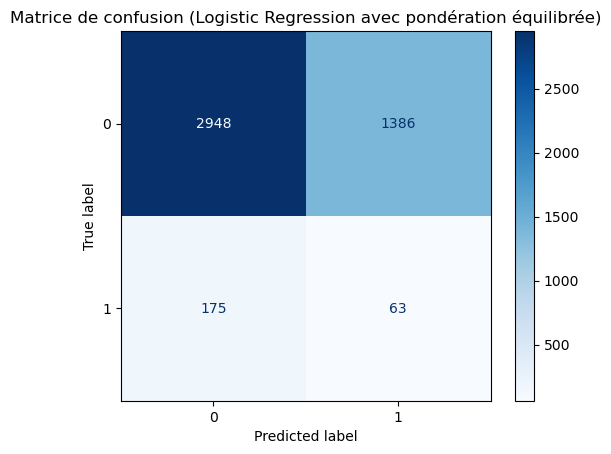

In [78]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred_balanced)

# Afficher la matrice de confusion
print("Matrice de Confusion :")
print(cm)


# Affichage de la matrice de confusion
ConfusionMatrixDisplay.from_estimator(logistic_clf_balanced, X_test_scaled, y_test, cmap='Blues')
plt.title('Matrice de confusion (Logistic Regression avec pondération équilibrée)')
plt.show()


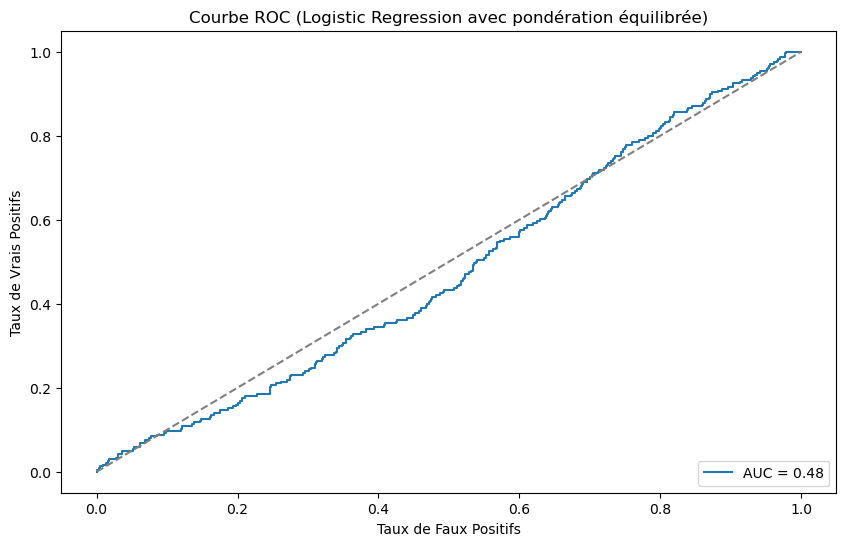

In [80]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calcul de la probabilité de la classe positive pour chaque observation
y_pred_proba = logistic_clf_balanced.predict_proba(X_test_scaled)[:, 1]

# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

# Affichage de la courbe ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC (Logistic Regression avec pondération équilibrée)')
plt.legend(loc='lower right')
plt.show()


## Autres Méthodes: Random Forest, Gradient Boosting et KNN

In [82]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


In [84]:
# Liste des modèles 
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)  # Ajuste le nombre de voisins selon ton besoin
}

# Stockage des résultats pour chaque modèle
results = {}

# Entraînement et évaluation des modèles
for name, model in models.items():
    # Entraîner le modèle
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Calcul des probabilités pour ROC AUC, sauf pour KNN si probability=False
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # Si predict_proba n'est pas disponible (comme pour KNN), utiliser les scores de décision
        y_pred_proba = model.predict(X_test_scaled)

    # Calcul des scores et stockage des résultats
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    results[name] = {
        "accuracy": accuracy,
        "auc": auc,
        "fpr": roc_curve(y_test, y_pred_proba)[0],
        "tpr": roc_curve(y_test, y_pred_proba)[1]
    }
    # Affichage du rapport de classification
    print(f"\nRapport de classification pour {name} :\n", classification_report(y_test, y_pred))
    print(f"Score AUC de {name} : {auc:.2f}")


Rapport de classification pour Random Forest :
               precision    recall  f1-score   support

           0       0.95      0.98      0.96      4334
           1       0.02      0.01      0.01       238

    accuracy                           0.93      4572
   macro avg       0.48      0.49      0.49      4572
weighted avg       0.90      0.93      0.91      4572

Score AUC de Random Forest : 0.64

Rapport de classification pour Gradient Boosting :
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      4334
           1       0.14      0.00      0.01       238

    accuracy                           0.95      4572
   macro avg       0.55      0.50      0.49      4572
weighted avg       0.91      0.95      0.92      4572

Score AUC de Gradient Boosting : 0.50

Rapport de classification pour K-Nearest Neighbors :
               precision    recall  f1-score   support

           0       0.95      0.98      0.97      4334
        

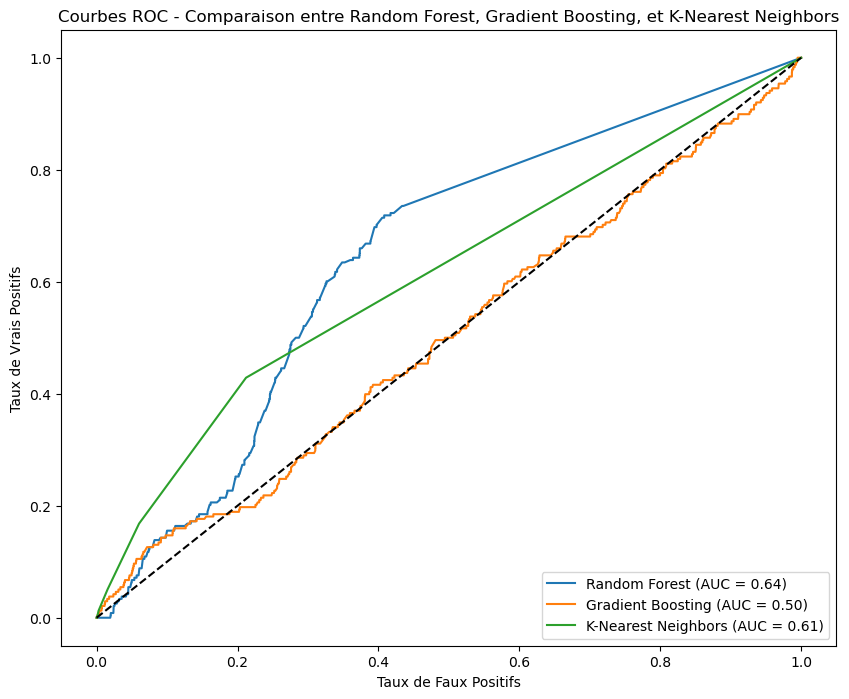

In [86]:
# Comparaison des courbes ROC pour Random Forest, Gradient Boosting et K-Nearest Neighbors
plt.figure(figsize=(10, 8))

# Tracer les courbes ROC de chaque modèle
for name, result in results.items():
    plt.plot(result["fpr"], result["tpr"], label=f"{name} (AUC = {result['auc']:.2f})")

# Ligne de référence pour un modèle aléatoire
plt.plot([0, 1], [0, 1], 'k--')

# Configuration du graphique
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbes ROC - Comparaison entre Random Forest, Gradient Boosting, et K-Nearest Neighbors')
plt.legend(loc="lower right")
plt.show()



In [97]:
# Résumé des scores de performance
summary_df = pd.DataFrame({
    "Modèle": results.keys(),
    "AUC": [result["auc"] for result in results.values()],
    "Accuracy": [result["accuracy"] for result in results.values()]
})

# Afficher les résultats
print("\nComparaison des performances des modèles:")
print(summary_df)




Comparaison des performances des modèles:
                Modèle       AUC  Accuracy
0        Random Forest  0.643520  0.928259
1    Gradient Boosting  0.501937  0.946850
2  K-Nearest Neighbors  0.613422  0.935914


## Choix du modèle

**-Random Forest**

AUC : 0.6435, indiquant une capacité de discrimination modérée. Ce modèle est capable de distinguer entre les entreprises HGF et non-HGF, mais reste limité dans sa performance.

Accuracy : 0.9283 (environ 93 %), ce qui montre une précision globale élevée. Cependant, ce score est principalement influencé par la classe majoritaire (non-HGF), ce qui peut ne pas bien refléter la capacité réelle du modèle à identifier les HHGF.

**- Gradient Boosting**

AUC : 0.5019, très proche de 0.5, ce qui suggère une capacité de discrimination proche du hasard. Cela indique que Gradient Boosting a du mal à distinguer efficacement les entreprises HGF des non-HGF.

Accuracy : 0.9469 (environ 95 %), légèrement meilleure que celle de Random Forest. Cependant, cette précision est probablement influencée par l'incapacité du modèle à identifier correctement les HGF, donc elle ne reflète pas une bonne performance sur la classe minoritaire.

**- K-Nearest Neighbors (KNN)**

AUC : 0.6134, indiquant une capacité de discrimination inférieure à celle de Random Forest, mais meilleure que celle de Gradient Boosting. Cela montre que KNN a une certaine capacité à distinguer les entreprises HHGF, bien que modérément.

Accuracy : 0.9359 (environ 94 %), ce qui est élevé, mais reflète surtout la performance sur la classe majoritaire. KNN montre une précision globale élevée, mais, comme pour les autres modèles, cela pourrait être trompeur pour la classe HHGF minoritaire.

**- Régression Logistique**

Précision globale : 0.6586 (environ 66 %), nettement inférieure aux modèles d'arbres de décision et à KNN. La régression logistique est particulièrement limitée pour la classe minoritaire, avec un recall de seulement 26 % et une précision de 4 % pour la classe HGF.

La faible AUC des méthodes de régression linéaire, proche de 0.5, suggère qu'elles ne parviennent pas à distinguer efficacement les HGF des non-HGF.
Conclusion Globale

Random Forest semble être le modèle le plus performant dans cette comparaison. Bien que l'AUC de 0.6435 soit modeste, elle est supérieure à celle des autres modèles, suggérant une meilleure capacité de discrimination entre les entreprises HHGF et non-HHGF.

Gradient Boosting et les méthodes de régression logistique ont des AUC proches de 0.5, ce qui indique qu'ils sont inefficaces pour identifier les entreprises HGF.

KNN offre une amélioration par rapport à Gradient Boosting et à la régression logistique en termes d'AUC, mais reste en deçà de Random Forest.

Dans l'ensemble, Random Forest se distingue comme étant le plus adapté à cette tâche, en montrant la meilleure capacité de discrimination. Cela suggère que Random Forest pourrait être le modèle le plus approprié pour des données présentant des relations non linéaires, bien qu'il soit nécessaire de continuer à tester d'autres techniques ou à ajuster les paramètres pour améliorer la performance sur la classe HGF.

In [92]:

# Initialiser et entraîner le modèle Random Forest 
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_clf.fit(X_train_scaled, y_train)

# Faire les prédictions sur l'ensemble de test (2012)
y_pred_rf = rf_clf.predict(X_test_scaled)

# Créer un DataFrame avec les résultats
results_2012 = test_data.copy()
results_2012['Predicted'] = y_pred_rf
results_2012['Actual'] = y_test.reset_index(drop=True)

# Filtrer pour ne garder que les entreprises prédites comme HHGF
hgf_predicted = results_2012[results_2012['Predicted'] == 1]

# Afficher les résultats des entreprises prédites comme HGF
print("Nombre d'entreprises prédites comme HGF en 2012 :", hgf_predicted.shape[0])
print("\nComparaison entre les prédictions et la situation réelle des entreprises prédites comme HGF en 2012 :")
print(hgf_predicted[['Predicted', 'Actual']])


Nombre d'entreprises prédites comme HGF en 2012 : 94

Comparaison entre les prédictions et la situation réelle des entreprises prédites comme HGF en 2012 :
       Predicted  Actual
206            1     0.0
712            1     0.0
758            1     0.0
1494           1     0.0
1678           1     0.0
...          ...     ...
89722          1     NaN
91332          1     NaN
94506          1     NaN
94874          1     NaN
97818          1     NaN

[94 rows x 2 columns]
